# Documentation #004

From #002, The analytical solutions for the ODE:
$$EX\left(t\right) = P \cdot e^{-k_{er}t}$$
$$OS\left(t\right) = \cfrac {P \cdot RLR \cdot k_{er}}{k_{er}-k_p} \cdot \left(e^{-k_pt}-e^{-k_{er}t}\right)$$
$$PD\left(t\right) = \cfrac {P \cdot RLR \cdot RRF}{k_{er}-k_p} \cdot \big(k_{er} \cdot \left(1-e^{-k_pt}\right)-k_p\cdot \left(1-e^{-k_{er}t}\right)\big)$$

Since the equations are nonlinear in nature, we will be modelling them using nonlinear regression methods. I will compare three nonlinear functions in R (nls, nlsList and nlme) to justify the usage of nonlinear mixed effect method.

## Nonlinear least square method [frequentist]
* The nls (short for nonlinear least squares) function in R fits a nonlinear regression line to a set of data.
* Nonlinear least squares are usually used to fit nonlinear regression models with iid Gaussian errors.
* nls ignores the grouping according to accident year cohorts and fits a single nonlinear model to all the data, as shown in the figure below. And then the regression line is used for generating predictions for all accident years, using the same parameters for every group.
* The formula for the nonlinear least square model is as follows:
$$y\left(t\right) \sim \mathcal{N}\left(\mu\left(t\right),\sigma^2\right)$$
$$\text{where} \; \mu(t) = f\left(P, k_{er}, k_{p}, RLR, RRF, t\right)$$
$$\text{and}\; f\left(P, k_{er}, k_{p}, RLR, RRF, t\right)=\begin{bmatrix} f_{os} \\ f_{pd}\end{bmatrix}$$

In [6]:
# > data <-read.csv("~/Dropbox/salarybubble/dataset/trial.csv")
# > data <-data[!(data$type==2),]
# > i <- order(data$dev)
# > plot(claims ~ dev, data)
# > nls_fit <- nls(claims ~ 100000*a/(a-b)*(exp(-b*dev)-exp(-a*dev)), data, start = list(a = 2.44, b = 0.4 ))
# > pred<-predict(nls_fit)
# > lines(data$dev[i], pred[i], col="red")

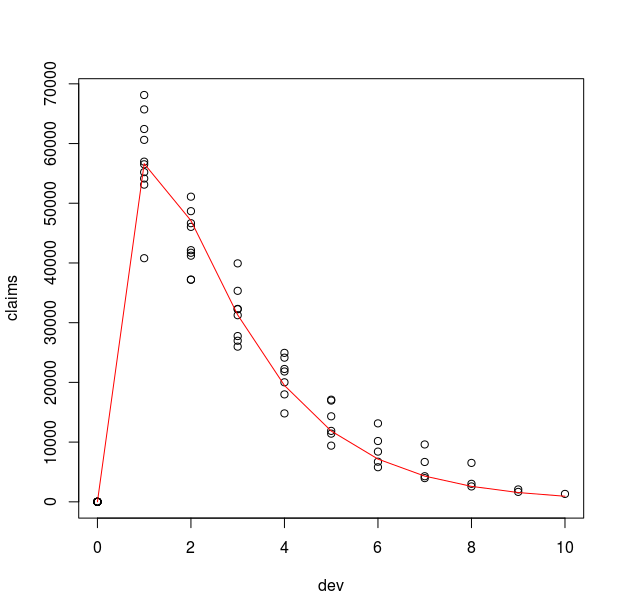

In [7]:
from IPython.display import Image
Image(filename='img/nls_curve.png')

From previous documentation, the parameter prediction result using nonlinear least square method:

In [ ]:
# Prediction result in R
## Bringing back the parameters to their original scale, logarithmic was applied to ensure positivity
#       ker       RLR        kp       RRF 
# 2.4375609 0.8985600 0.4231800 0.6466241 

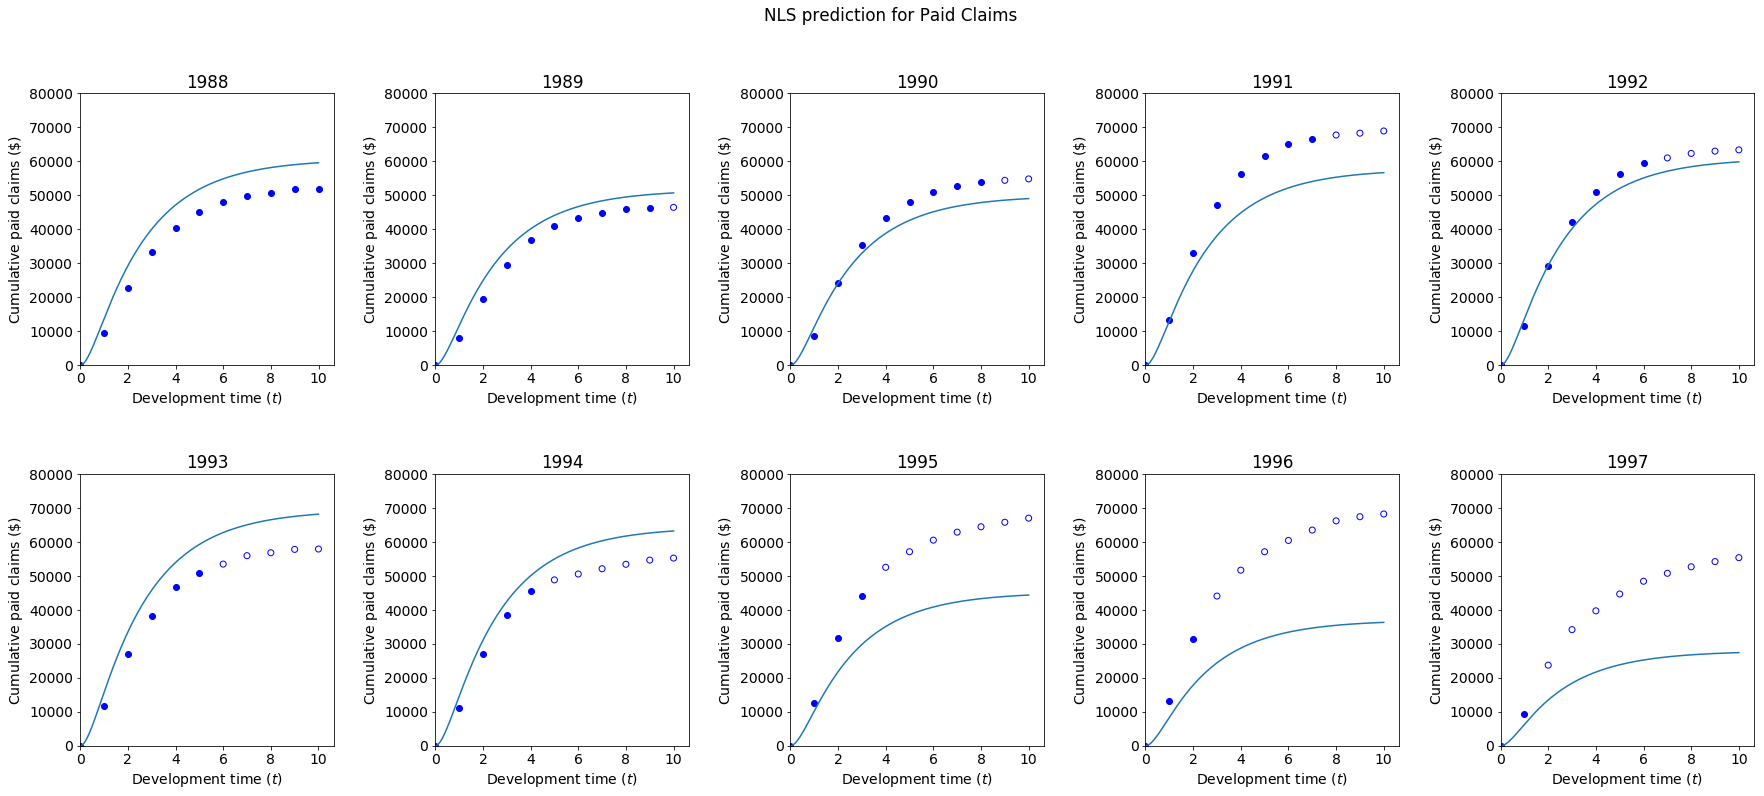

In [3]:
### For OS, change 2 parts ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

gd = pd.read_csv('graph_data.csv')

######################
#     PARAMETERS     #
######################
ker = 2.4375609
kp  = 0.4231800
RLR = 0.8985600
RRF = 0.6466241

##################
#     GLOBAL     #
##################
### For OS (part 1) ###
# pd_test = gd[gd['type'] == 'OS (test)']
# pd_train = gd[gd['type'] == 'OS (train)']

pd_test = gd[gd['type'] == 'PD (test)']
pd_train = gd[gd['type'] == 'PD (train)']

prem = gd.loc[(gd['dev']==0) & (gd['type']=='OS (train)'), \
             ['accident_year','premium']].set_index("accident_year")

## Set up plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,12))
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)
fig.suptitle('NLS prediction for Paid Claims')

####################
#     SUBPLOTS     #
####################
# From data
for ax, i in zip(axes.flatten(), range(gd.accident_year.min(),gd.accident_year.max()+1)):
    bla_train = pd_train.loc[pd_train['accident_year'] == i, ['dev','claims']].values.tolist()
    bla_test = pd_test.loc[pd_test['accident_year'] == i, ['dev','claims']].values.tolist()

    T_traind = []
    PD_traind = []
    T_testd=[]
    PD_testd=[]
    
    for q in bla_train:
        t = q[0]
        os = q[1]
        T_traind.append(t)
        PD_traind.append(os)

    for p in bla_test:
        t = p[0]
        os = p[1]
        T_testd.append(t)
        PD_testd.append(os)

# From simulation
    t = np.linspace(0, 10, 1000)
    p = prem.loc[i,'premium']
    
    ### For OS (part 2) ###
#     OS = p * RLR * ker / (ker - kp) * (np.exp(-kp * t) - np.exp(-ker * t))
#     ax.plot(t, OS, label='OS', color='orange')
#     ax.scatter(T_traind, PD_traind, color='r', label = 'OS train')
#     ax.scatter(T_testd, PD_testd, color='r', facecolors='none', label = 'OS test')
#     ax.set(title=i,xlabel='Development time $(t)$',ylabel='Outstanding claims $(\$)$')
#     ax.set_ylim(0,80000)

    PD = p * RLR * RRF / (ker - kp) * (ker * (1 - np.exp(-kp * t)) - kp * (1 - np.exp(-ker * t))) 
    ax.plot(t, PD, label='PD')
    ax.scatter(T_traind, PD_traind, color='blue', label = 'PD train')
    ax.scatter(T_testd, PD_testd, color='blue', facecolors='none', label = 'PD test')
    ax.set(title=i,xlabel='Development time $(t)$',ylabel='Cumulative paid claims $(\$)$')
    ax.set_ylim(0,80000)
    
    ax.set_xlim(0)
    plt.rcParams.update({'font.size':14})

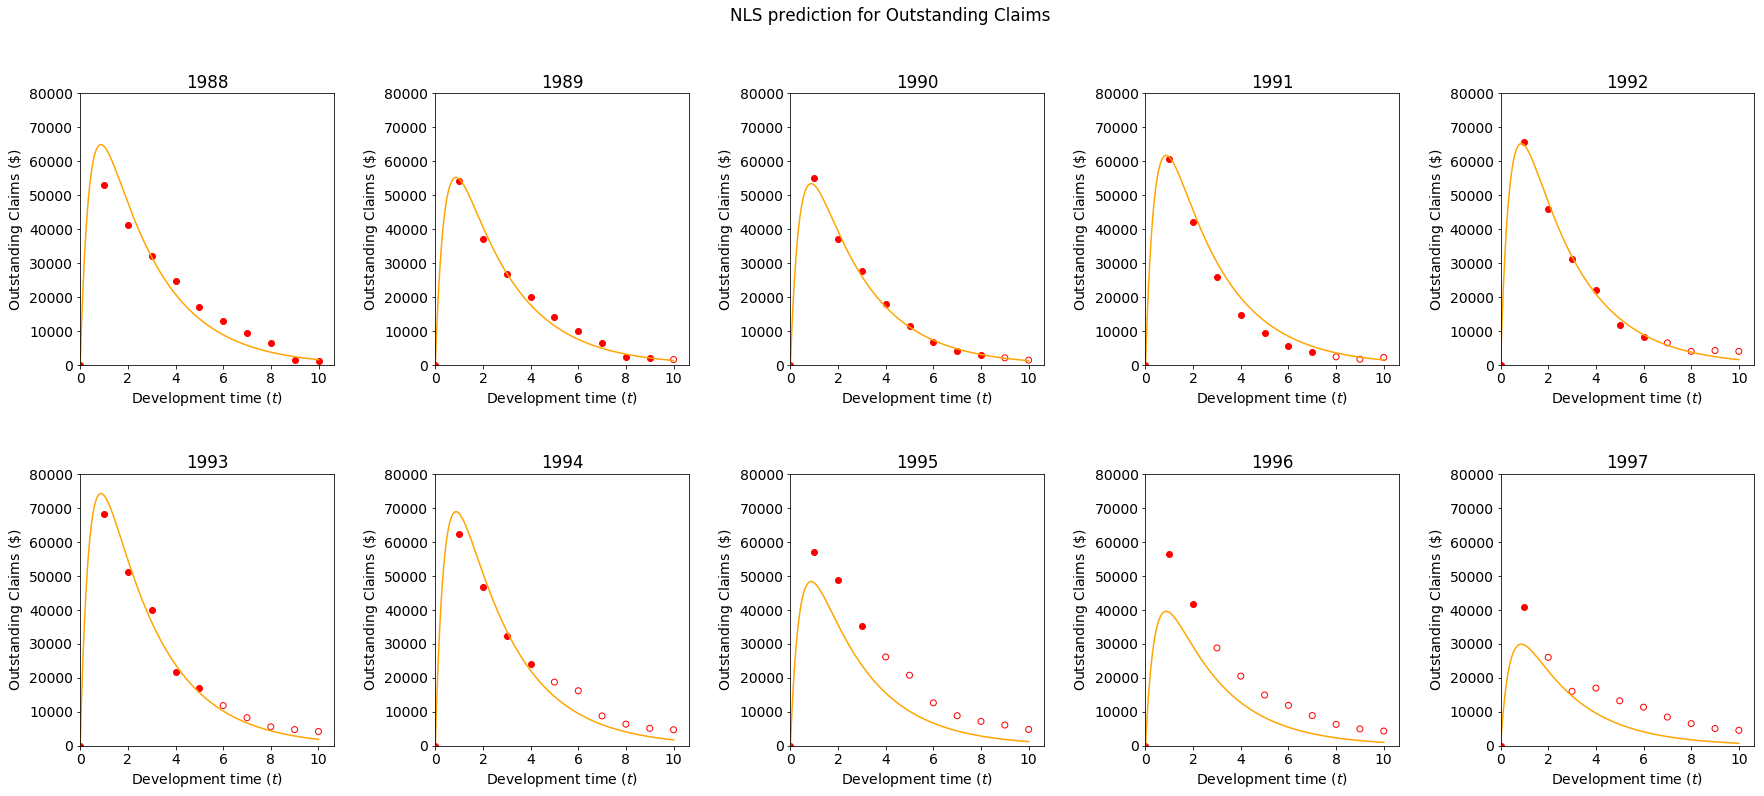

In [49]:
# For OS

The model is able to capture the developing pattern of both cumulative paid and oustanding claims, however predictions are not quite accurate.
We can divide the paid claims and outstanding claims by premium in order to see the true colours of the nonlinear least square method, since different accident years cohort may have different performances.
$$Loss Ratio (\%) = \cfrac{Loss}{Premium}$$

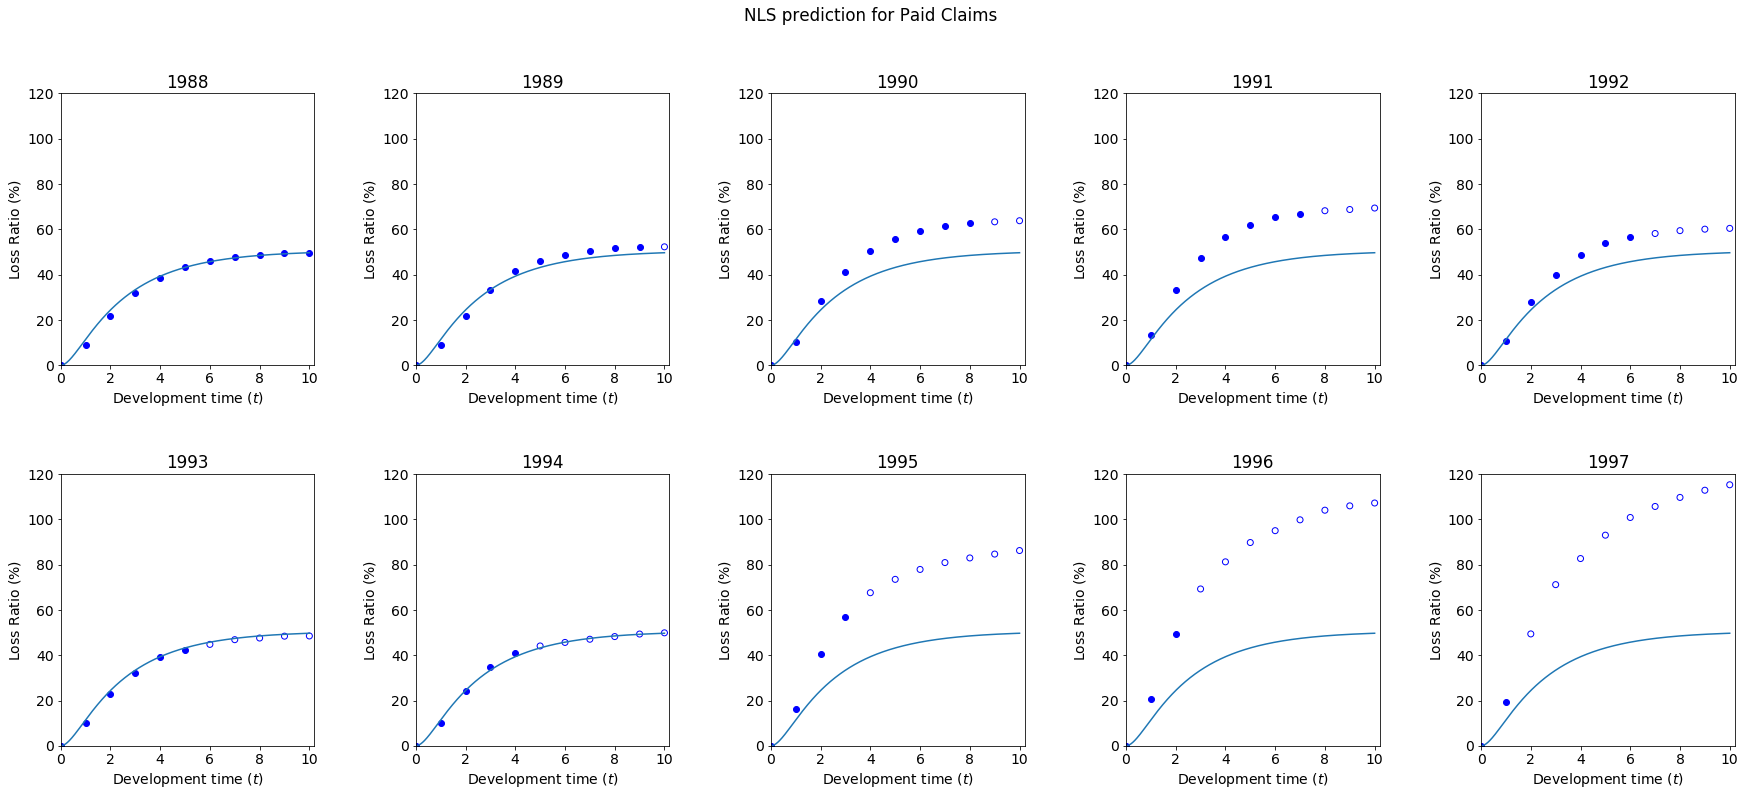

In [17]:
### For OS (part 1) ###
# pd_test = gd[gd['type'] == 'OS (test)']
# pd_train = gd[gd['type'] == 'OS (train)']

pd_test = gd[gd['type'] == 'PD (test)']
pd_train = gd[gd['type'] == 'PD (train)']

## Set up plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,12))
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)
fig.suptitle('NLS prediction for Paid Claims')

####################
#     SUBPLOTS     #
####################
# From data
for ax, i in zip(axes.flatten(), range(gd.accident_year.min(),gd.accident_year.max()+1)):
    bla_train = pd_train.loc[pd_train['accident_year'] == i, ['dev','claims']].values.tolist()
    bla_test = pd_test.loc[pd_test['accident_year'] == i, ['dev','claims']].values.tolist()

    T_traind = []
    PD_traind = []
    T_testd=[]
    PD_testd=[]
    
    for q in bla_train:
        t = q[0]
        os = q[1]
        T_traind.append(t)
        PD_traind.append(os)

    for p in bla_test:
        t = p[0]
        os = p[1]
        T_testd.append(t)
        PD_testd.append(os)

# From simulation
    t = np.linspace(0, 10, 1000)
    p = prem.loc[i,'premium']
    
    ### For OS (part 2) ###
#     OS = p * RLR * ker / (ker - kp) * (np.exp(-kp * t) - np.exp(-ker * t))
#     LR = OS/p*100
#     ax.plot(t, LR, label='LR', color='orange')
#     ax.scatter(T_traind, PD_traind/p*100, color='r', label = 'OS train')
#     ax.scatter(T_testd, PD_testd/p*100, color='r', facecolors='none', label = 'OS test')
#     ax.set(title=i,xlabel='Development time $(t)$',ylabel='Loss Ratio $(\%)$')
#     ax.set_ylim(0,100)

    PD = p * RLR * RRF / (ker - kp) * (ker * (1 - np.exp(-kp * t)) - kp * (1 - np.exp(-ker * t))) 
    LR = PD/p*100
    ax.plot(t, LR, label='LR')
    ax.scatter(T_traind, PD_traind/p*100, color='blue', label = 'PD train')
    ax.scatter(T_testd, PD_testd/p*100, color='blue', facecolors='none', label = 'PD test')
    ax.set(title=i,xlabel='Development time $(t)$',ylabel='Loss Ratio $(\%)$')
    ax.set_ylim(0,120)
    
    ax.set_xlim(0,10.2)
    plt.rcParams.update({'font.size':14})

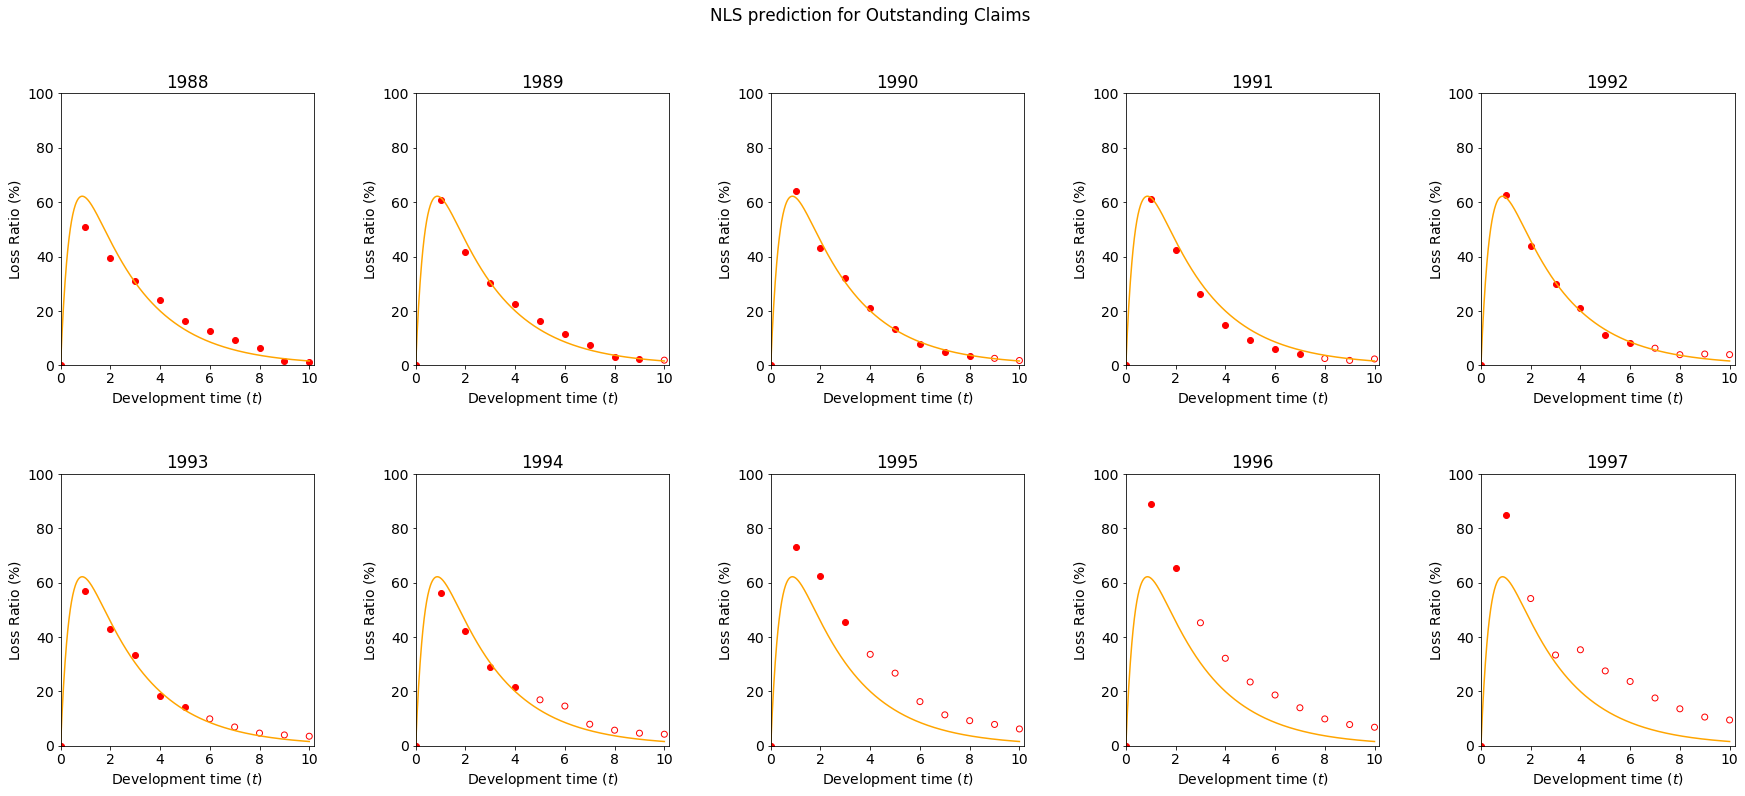

In [50]:
# For OS

 * The prediction curve (solid line) is the same across accident years by keeping the same parameters for all accident years, which is unrealistic.
 * Pinheiro and Bates mentioned in their book that "Probably the most important drawback of using an nls model with grouped data is that it prevents us from understanding the true structure of the data and from considering different sources of variability that are of interest in themselves.... important consideration...is knowing how the concentration profiles vary among individuals".

### nlsList
* Though not shown here, nlsList is another extreme of nls. It applies nls to each accident year cohort and fits a regression line for each year.
* That is to say,  nlsList will end up with 10 times more parameters if we were to apply it to our data.
* The problem is that this kind of modelling will reduce the credibility of each parameter due to the number of parameters relative to available data.
* So nlme is really a compromise between nls and nlsList, such that some parameters are fixed across groups, some vary across groups.

That is why we are going to let the random effects parameters vary according to accident years using the nonlinear mixed effect method, i.e. different ULR for different accident year cohorts. The fixed effects parameters $k_{er}$ and $k_p$ means the rate of reporting and settlement are the same for each accident years. We focus first on the random effects and then come back to the fixed effects later.

## Nonlinear Mixed Effect Method [frequentist]
The nlme model:

Using the result from the earlier documentation:

In [ ]:
## Prediction result in R
# Rescaling and calculating ULR for each accident year
#        RLR   RRF   ULR
# 1988 0.853 0.593 0.506
# 1989 0.925 0.577 0.534
# 1990 0.968 0.673 0.651
# 1991 0.910 0.798 0.727
# 1992 0.946 0.663 0.627
# 1993 0.899 0.562 0.505
# 1994 0.885 0.611 0.540
# 1995 1.232 0.724 0.892
# 1996 1.406 0.785 1.104
# 1997 1.382 0.734 1.014

## Rescaling fixed effects
# > m1_fe <- data.table(summary(m1)$tTable)[, exp(Value + 0.5*`Std.Error`^2)]
# > names(m1_fe) <- c("ker", "RLR", "kp", "RRF")
# > m1_fe
#       ker       RLR        kp       RRF 
# 1.5096157 1.0251880 0.4520317 0.6680359 

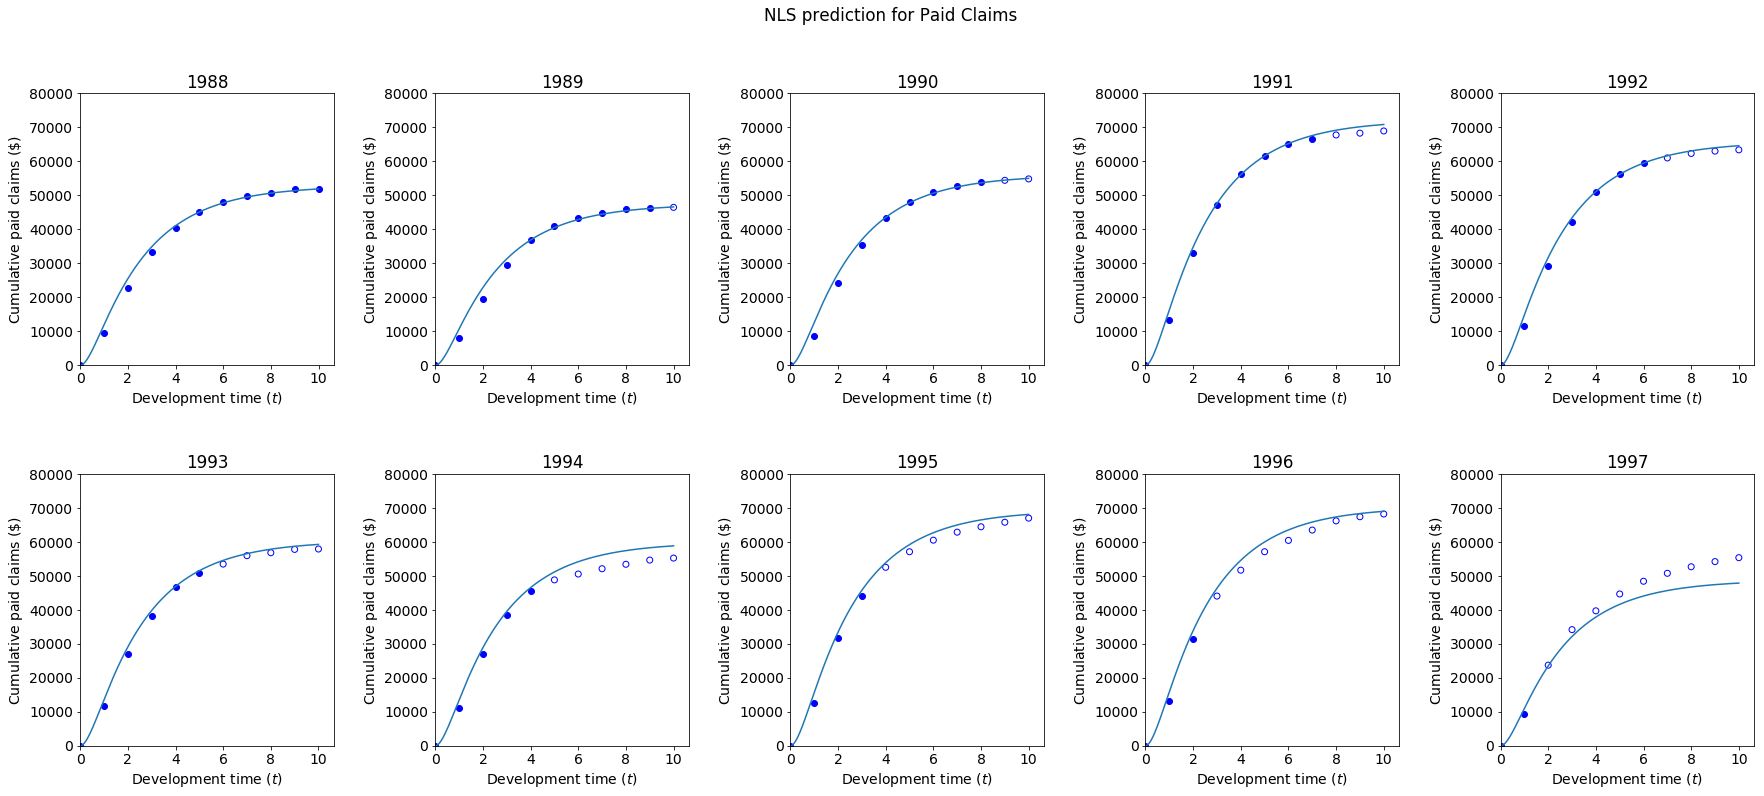

In [9]:
############################
#     FIXED PARAMETERS     #
############################
f_ker = 1.5096157
f_kp = 0.4520317

##################
#     GLOBAL     #
##################
gd = pd.read_csv('graph_data.csv')
rand_param = (pd.read_csv('/home/ziqingang/Dropbox/salarybubble/dataset/rounded_para.csv')).set_index("Unnamed: 0")

### For OS (part 1) ###
# pd_test = gd[gd['type'] == 'OS (test)']
# pd_train = gd[gd['type'] == 'OS (train)']

pd_test = gd[gd['type'] == 'PD (test)']
pd_train = gd[gd['type'] == 'PD (train)']

prem = gd.loc[(gd['dev']==0) & (gd['type']=='OS (train)'), \
             ['accident_year','premium']].set_index("accident_year")

## Set up plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,12))
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)
fig.suptitle('NLS prediction for Paid Claims')

####################
#     SUBPLOTS     #
####################
# From data
for ax, i in zip(axes.flatten(), range(gd.accident_year.min(),gd.accident_year.max()+1)):
    bla_train = pd_train.loc[pd_train['accident_year'] == i, ['dev','claims']].values.tolist()
    bla_test = pd_test.loc[pd_test['accident_year'] == i, ['dev','claims']].values.tolist()

    T_traind = []
    PD_traind = []
    T_testd=[]
    PD_testd=[]
    
    for q in bla_train:
        t = q[0]
        os = q[1]
        T_traind.append(t)
        PD_traind.append(os)

    for p in bla_test:
        t = p[0]
        os = p[1]
        T_testd.append(t)
        PD_testd.append(os)

# From simulation
    t = np.linspace(0, 10, 1000)
    p = prem.loc[i,'premium']
    RLR = rand_param.loc[i,'RLR']
    RRF = rand_param.loc[i,'RRF']
    
    ### For OS (part 2) ###
#     OS = p * RLR * ker / (ker - kp) * (np.exp(-kp * t) - np.exp(-ker * t))
#     ax.plot(t, OS, label='OS', color='orange')
#     ax.scatter(T_traind, OS_traind, color='r', label = 'OS train')
#     ax.scatter(T_testd, OS_testd, color='r', facecolors='none', label = 'OS test')
#     ax.set(title=i,xlabel='Development time $(t)$',ylabel='Outstanding claims $(\$)$')
#     ax.set_ylim(0,80000)

    
    PD = p * RLR * RRF / (ker - kp) * (ker * (1 - np.exp(-kp * t)) - kp * (1 - np.exp(-ker * t))) 
    ax.plot(t, PD, label='PD')
    ax.scatter(T_traind, PD_traind, color='blue', label = 'PD train')
    ax.scatter(T_testd, PD_testd, color='blue', facecolors='none', label = 'PD test')
    ax.set(title=i,xlabel='Development time $(t)$',ylabel='Cumulative paid claims $(\$)$')
    ax.set_ylim(0,80000)
    
    ax.set_xlim(0)
    plt.rcParams.update({'font.size':14})

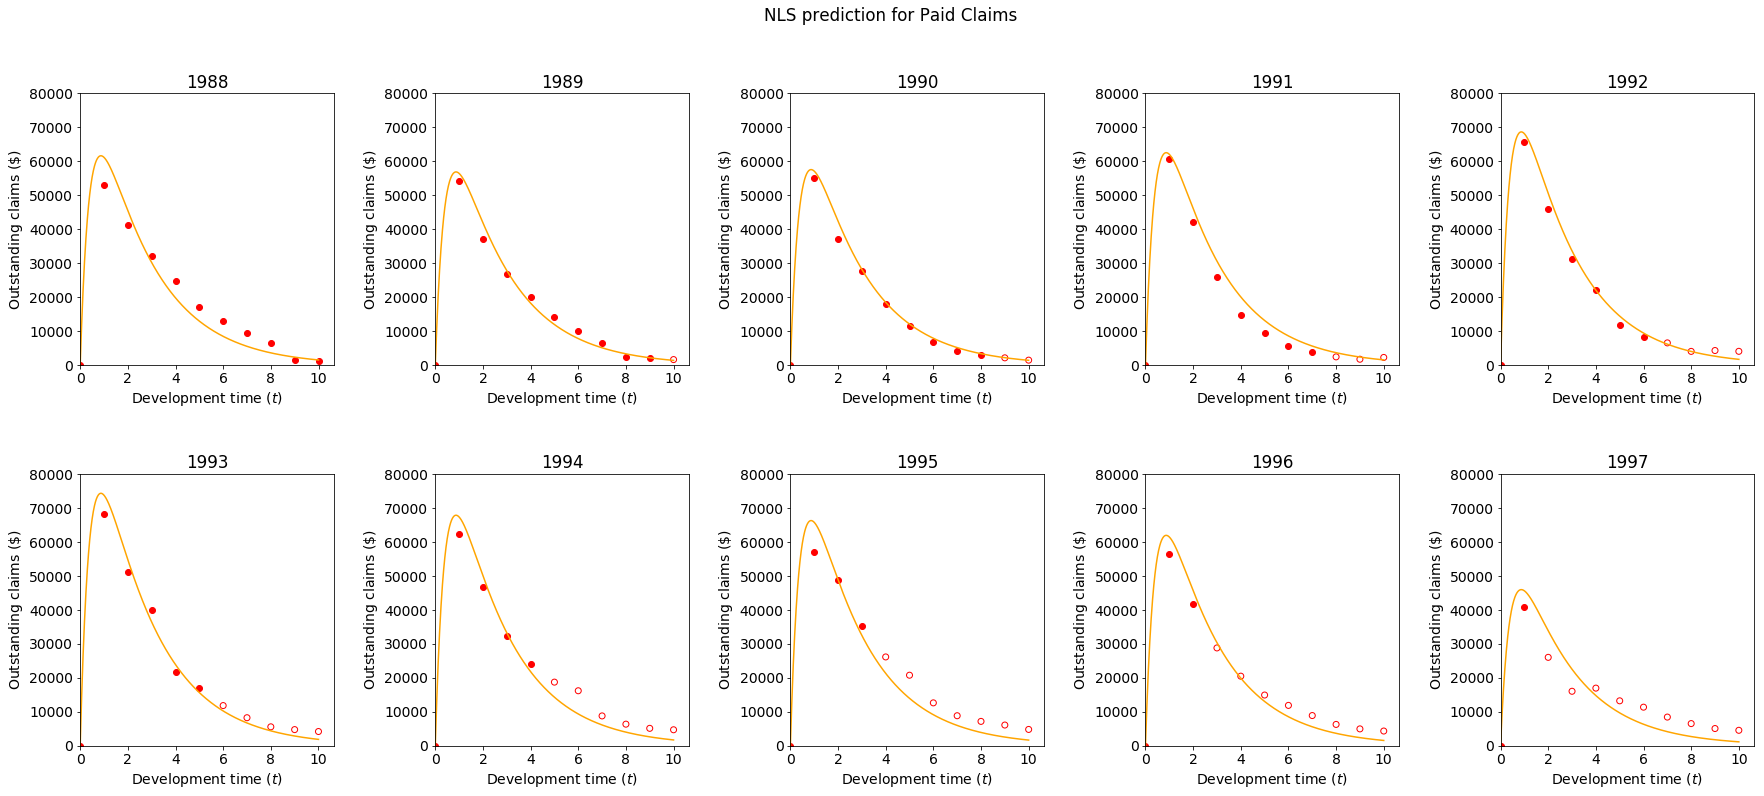

In [11]:
# For OS

The predictions look pretty good now. The figures of loss ratios are also plotted as well.

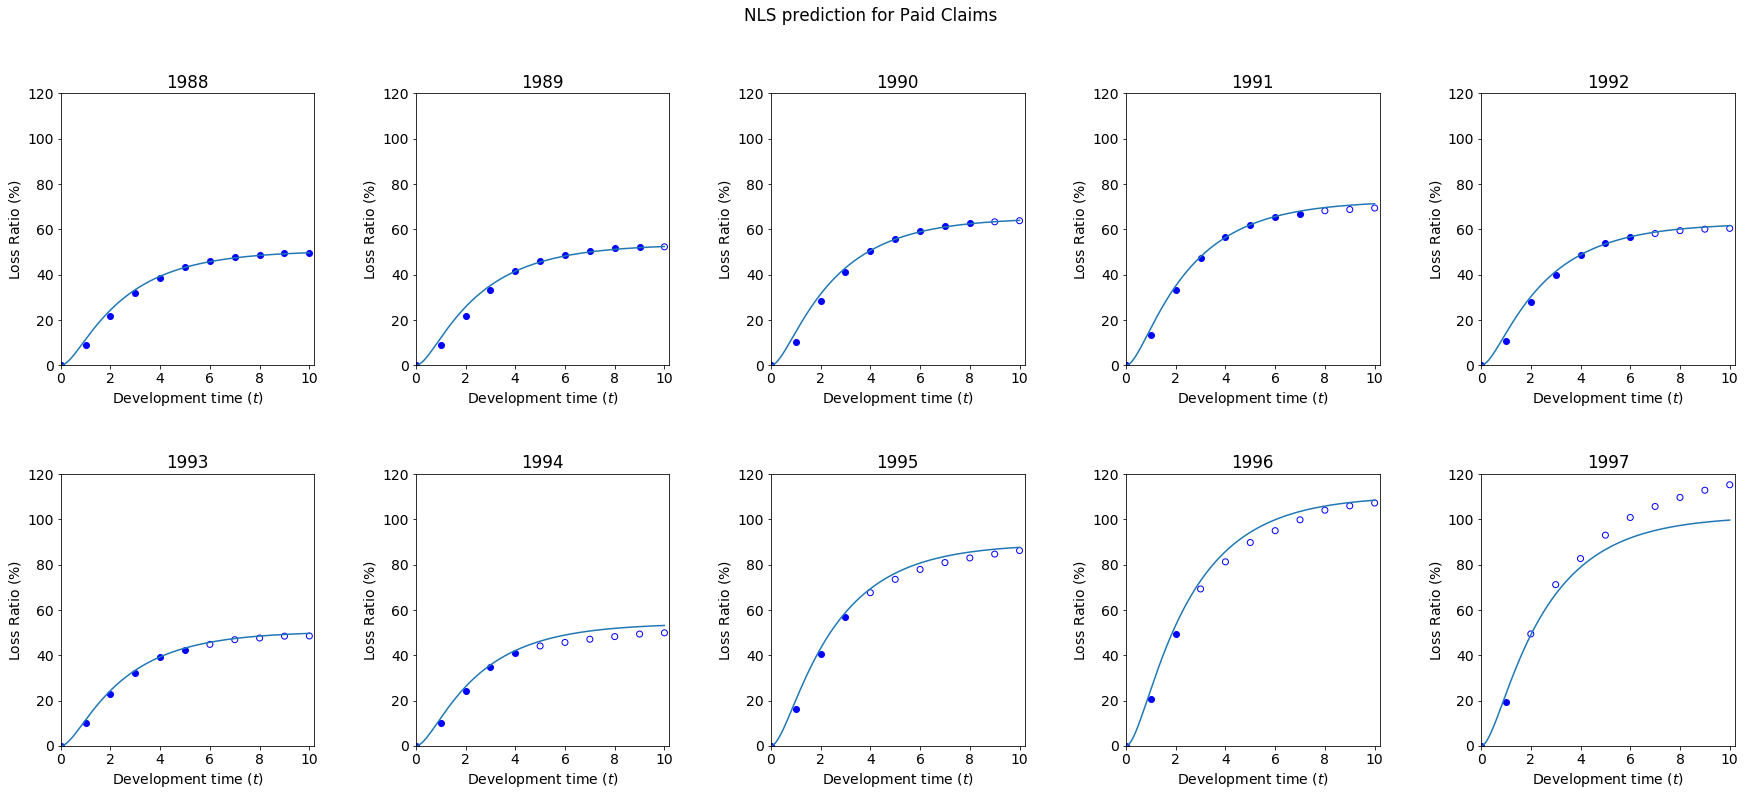

In [95]:
### For OS (part 1) ###
# pd_test = gd[gd['type'] == 'OS (test)']
# pd_train = gd[gd['type'] == 'OS (train)']

pd_test = gd[gd['type'] == 'PD (test)']
pd_train = gd[gd['type'] == 'PD (train)']

## Set up plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30,12))
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)
fig.suptitle('NLS prediction for Paid Claims')

####################
#     SUBPLOTS     #
####################
# From data
for ax, i in zip(axes.flatten(), range(gd.accident_year.min(),gd.accident_year.max()+1)):
    bla_train = pd_train.loc[pd_train['accident_year'] == i, ['dev','claims']].values.tolist()
    bla_test = pd_test.loc[pd_test['accident_year'] == i, ['dev','claims']].values.tolist()

    T_traind = []
    PD_traind = []
    T_testd=[]
    PD_testd=[]
    
    for q in bla_train:
        t = q[0]
        os = q[1]
        T_traind.append(t)
        PD_traind.append(os)

    for p in bla_test:
        t = p[0]
        os = p[1]
        T_testd.append(t)
        PD_testd.append(os)

# From simulation
    t = np.linspace(0, 10, 1000)
    p = prem.loc[i,'premium']
    RLR = rand_param.loc[i,'RLR']
    RRF = rand_param.loc[i,'RRF']
    
    ### For OS (part 2) ###
#     OS = p * RLR * ker / (ker - kp) * (np.exp(-kp * t) - np.exp(-ker * t))
#     LR = OS/p*100
#     ax.plot(t, LR, label='LR', color='orange')
#     ax.scatter(T_traind, PD_traind/p*100, color='r', label = 'OS train')
#     ax.scatter(T_testd, PD_testd/p*100, color='r', facecolors='none', label = 'OS test')
#     ax.set(title=i,xlabel='Development time $(t)$',ylabel='Loss Ratio $(\%)$')
#     ax.set_ylim(0,100)

    PD = p * RLR * RRF / (ker - kp) * (ker * (1 - np.exp(-kp * t)) - kp * (1 - np.exp(-ker * t))) 
    LR = PD/p*100
    ax.plot(t, LR, label='LR')
    ax.scatter(T_traind, PD_traind/p*100, color='blue', label = 'PD train')
    ax.scatter(T_testd, PD_testd/p*100, color='blue', facecolors='none', label = 'PD test')
    ax.set(title=i,xlabel='Development time $(t)$',ylabel='Loss Ratio $(\%)$')
    ax.set_ylim(0,120)
    
    ax.set_xlim(0,10.2)
    plt.rcParams.update({'font.size':14})


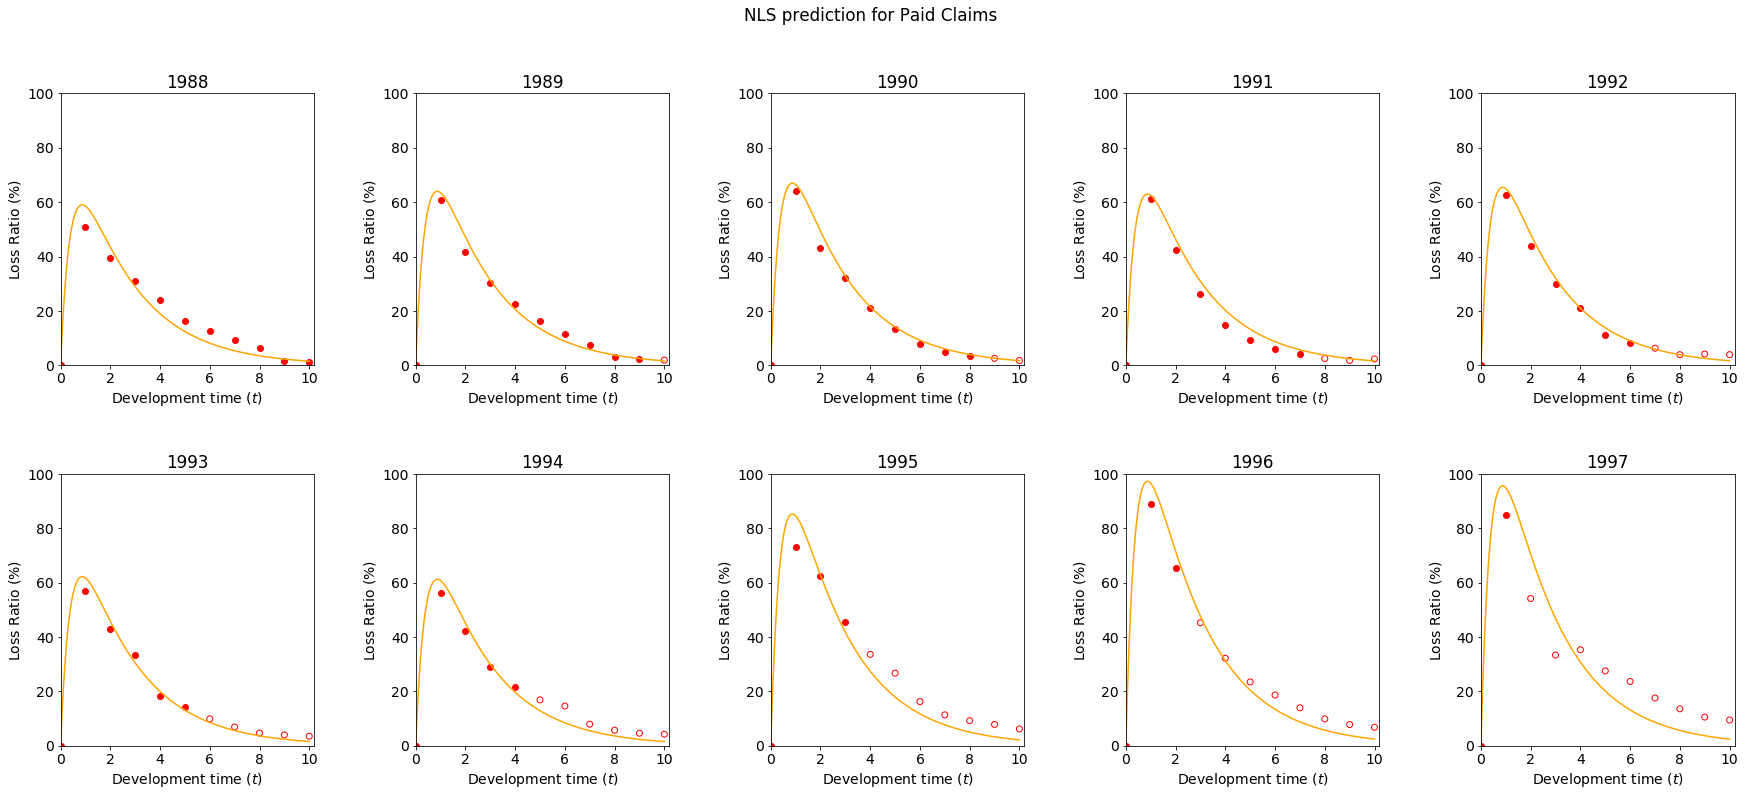

In [18]:
# For OS

* So by using the nonlinear mixed effects method, we can observe very easily that, after converting to loss ratios the predictions now vary by accident years.
* While predictions for paid claims may seem reasonable, we can notice that for some later development time in some accident years, the predictions may underestimate the outstanding claims. That is to say, the claims may take longer to develop to ultimate. 
* In his paper, Jake has suggested to allow the fixed effect parameters to depend on development time, for example,
$$k_{er}(t)=\beta_{er}\cdot t$$
$$k_p(t) = \cfrac{\beta_{p,1}}{\beta_{p,2}+t}$$

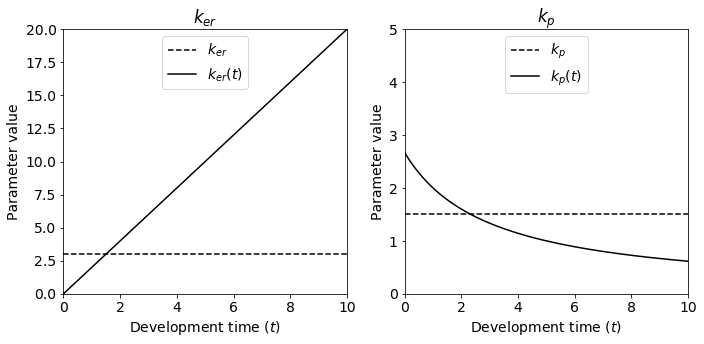

In [93]:
t = np.linspace(0, 10, 1000)
beta = 2
beta_i = 8
beta_ii = 3

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.axhline(3, linestyle='--', color='black', label = '${k_{er}}$')
ax1.plot(t,beta*t, color='k', label = "${k_{er}(t)}$")
ax1.set_xlim(0,10)
ax1.set_ylim(0,20)
ax1.legend(loc='upper center')
ax1.set_xlabel('Development time $(t)$')
ax1.set_ylabel('Parameter value')
ax1.set_title("$k_{er}$")

ax2.axhline(1.5, linestyle='--', color='black', label = '${k_{p}}$')
ax2.plot(t,beta_i/(beta_ii+t), color='k', label = "${k_{p}(t)}$")
ax2.set_xlim(0,10)
ax2.set_ylim(0,5)
ax2.legend(loc='upper center')
ax2.set_xlabel('Development time $(t)$')
ax2.set_ylabel('Parameter value')
ax2.set_title("$k_{p}$")
# fig = plt.figure(figsize = (8,6))

plt.tight_layout()

* His example to let $k_{er}$ increase in time was to capture delays between claims and report, since whatever delays that might happen, eventually they will get reported towards the end of the development.
* Outstanding claims may take longer to develop to ultimate, especially those at the later development time. Because at that point of time, those claims that remain are those that might be undergoing or awaiting litigation (those that involve court cases, and the amount of these claims are usually quite large). Hence, Jake proposed a decreasing rate function for $k_p$.
* Jake has demonstrated the incorporation of time-depending rate parameters in this example in his paper and it actually described the outstanding patterns quite accurately, the $\beta$ values in these functions can also be estimated using nlme.

Since I wasn't able to run his codes, I think I'll stop here for frequentists methods and see if Bayesian methods can overcome these problems. I will probably have to study the nlme package in R more thoroughly to do a more independent work, but for now I'll turn my focus back to Bayesian methods.

### Next up 

### References
Pinheiro, J. C. & Bates, D. M. (2000) Mixed-Effects Models in S and S-Plus,New York: Springer-Verlag

https://www.casact.org/pubs/forum/16sforum/Morris.pdf

https://magesblog.com/post/hierarchical-compartmental-reserving-models/